#<font color="yellow"> External Fraud Detection Engine Integration </font>

The sample is intended to demonstrate robust fraud detection mechanism in real-time.<br>
this use-case consists of 2 seperate steps:<br>
Step 1: Integrate a transaction <br>
Step 2: Change transaction status<br>

Please see the schema of the workflow below:
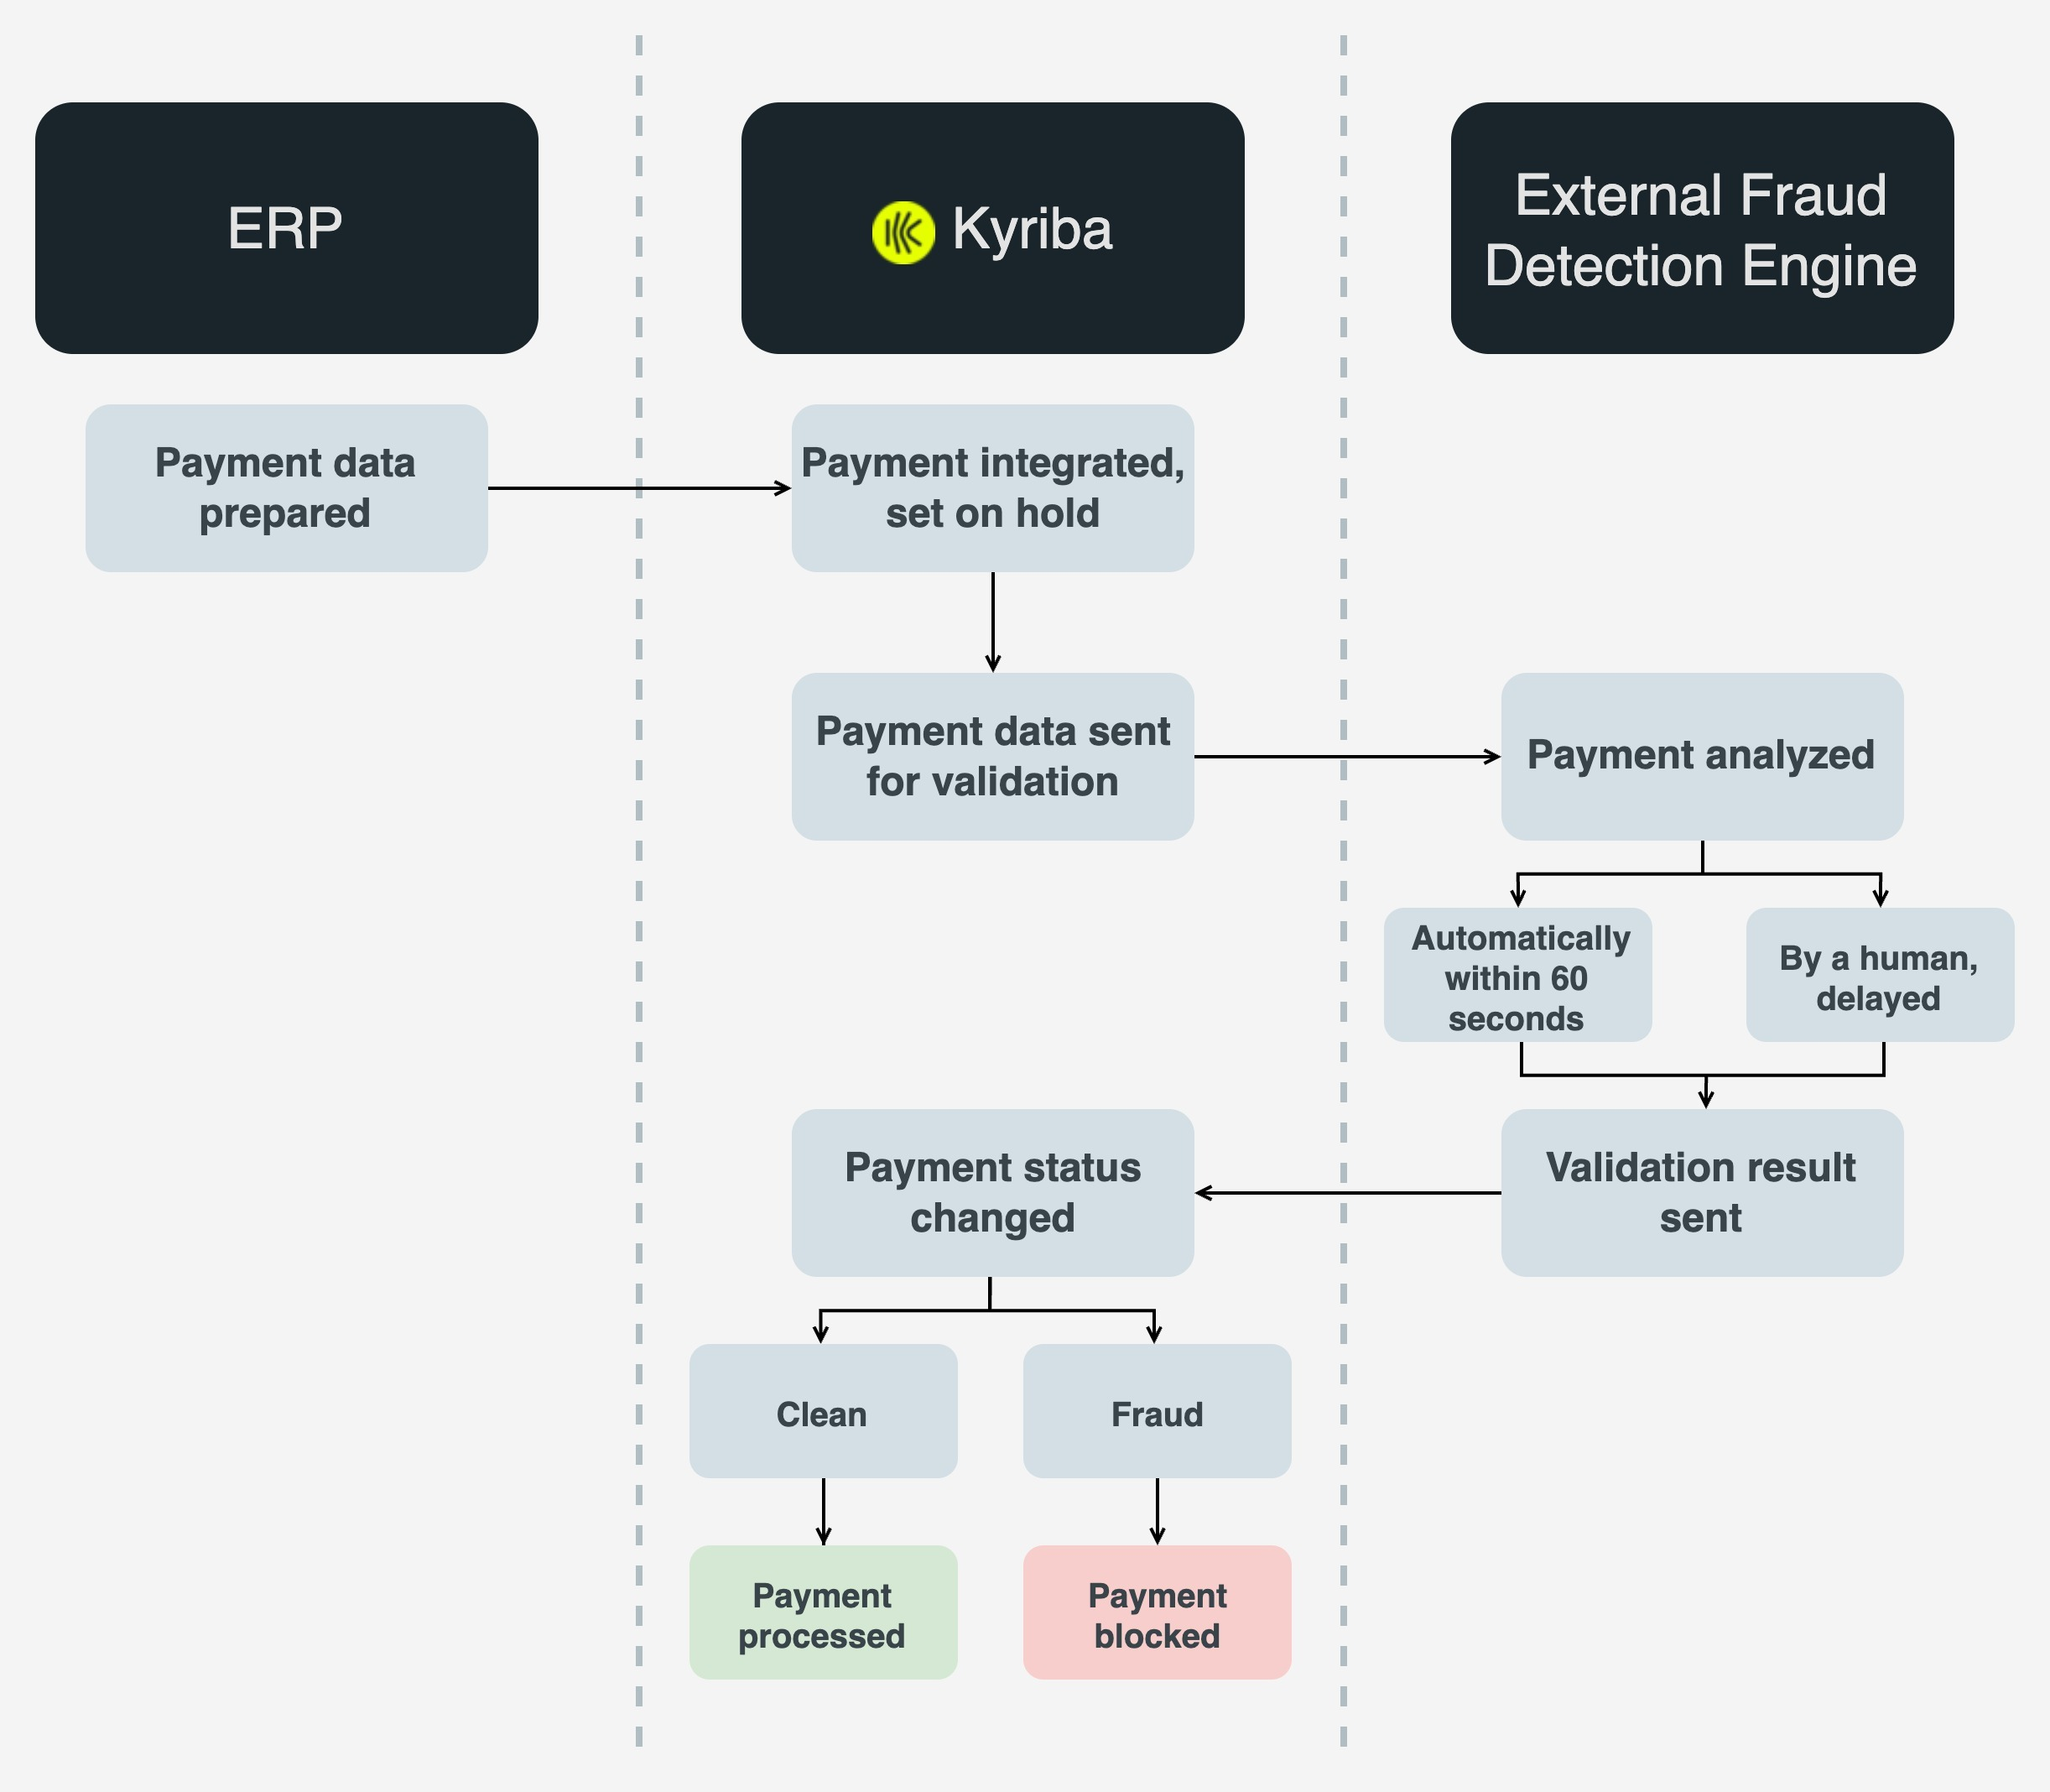

## <font color='yellow'>Step 0.1: Code for token generation and API management



In [ ]:
#@title Import custom modules
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta, date
import dateutil.relativedelta
import calendar
from IPython.display import display, HTML
from google.colab import widgets
import ipywidgets as widgets
from google.colab import files
import requests
import sys
from subprocess import getstatusoutput
import importlib
import json
from uuid import uuid4


branch = 'main'
rm = getstatusoutput("rm Colab_shared_code_for_API_usage -rf ")
clone = getstatusoutput("git clone -l -s --branch " +  branch + " https://github.com/kyriba/Colab_shared_code_for_API_usage.git")

try:
  importlib.reload(sample_requests)
except:
  print()
from Colab_shared_code_for_API_usage import sample_requests


## <font color='yellow'>Step 0.2: Connect and  retrieve token</font>

In [ ]:
#@title <font color='lime'>Connect</font>
print('token:')
global token
token = sample_requests.login()


token:
token 0374c2b4-ccea-43f0-baae-d0af23156608


## <font color='yellow'>Step 1: Integrate a transaction</font>

In [ ]:
#@title <font color='lime'>Import a transaction</font>

#@markdown Select a scenario by choosing transaction status.
status = 'CLEAN TRANSACTION' #@param ["PUT TRANSACTION ON HOLD", "FRAUD CONFIRMED", "CLEAN TRANSACTION"] {type:"string"}

#@markdown Check the box to see integration logs.
show_traces = False #@param {type:"boolean"}

status_to_transaction_code = {
    "PUT TRANSACTION ON HOLD": "SITD",
    "FRAUD CONFIRMED": "SIFC",
    "CLEAN TRANSACTION": "SICL"
}

transaction_code = status_to_transaction_code.get(status)

time = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
date = datetime.now().strftime("%d%m%Y")
transaction_date = datetime.now().strftime("%Y-%m-%d")

reference = f"SPI_{transaction_code}_{time}"
filename = f"FRAUD_SPI_{transaction_code}_{time}.txt"
data = f"{date};15000.00;SPI_PET;{reference};{transaction_code}"

import_response = sample_requests.import_data(token, data, filename, "DEMO_FRAUD_SPI", True, show_traces)


token 0374c2b4-ccea-43f0-baae-d0af23156608
..
Complete


In [ ]:
#@title <font color='lime'>Check transaction status</font>

status_response = sample_requests.get_results(token, '/v1/payment/transfers/status?filter=reference==' + reference)
transaction_data = json.loads(status_response)["results"][0]
transaction_uuid = transaction_data["uuid"]

print("Reference:", reference)
print("Status:", transaction_data["status"])
print("Next Action:", transaction_data["nextAction"])

Reference: SPI_SICL_2025-04-30T14:09:35
Status: REGISTERED
Next Action: REMIT


In [ ]:
#@title <font color='lime'>(OPTIONAL) API request and response to/from the Fraud Detection Engine.</font>

#@markdown Check the box to see an example of the request body sent to the Fraud Detection Engine.
show_request_body = False #@param {type:"boolean"}
#@markdown Check the box to see an example of the response body received from the Fraud Detection Engine.
show_response_body = True #@param {type:"boolean"}

fraud_engine_server_url = 'https://kyribadevportal.pythonanywhere.com/fraud/v1/fraud-detection/transfers-request'


alert_request_body = {
  "kyribaCustomer": {
    "code": "APISANDBOX01"
  },
  "transfers": [
    {
      "uuid": transaction_uuid,
      "transactionNumber": transaction_data['transactionNumber'],
      "screeningContext": "URGENT",
      "transactionType": "INTERNATIONAL_TRANSFER",
      "transactionCode": {
        "code": transaction_code
      },
      "amount": 15000.00,
      "currency": {
        "code": "AUD"
      },
      "transactionDate": transaction_date,
      "valueDate": transaction_date,
      "beneficiaryDate": transaction_date,
      "orderingCustomer": {
        "company": {
          "code": "COMPANY01",
          "description1": "Company 01 (US)"
        },
        "country": {
          "code": "US"
        }
      },
      "payor": {
        "company": {
          "code": "COMPANY01",
          "description1": "Company 01 (US)"
        },
        "country": {
          "code": "US"
        }
      },
      "counterparty": {
        "name": "Good company",
        "name2": "US department",
        "type": "EXTERNAL",
        "thirdPartyType": "ORGANIZATION",
        "address": {
          "country": {
            "code": "US"
          },
          "street1": "Street 123",
          "street2": "Office 3",
          "city": "San Diego",
          "state": "California",
          "zipCode": "91911"
        },
        "bankAccount": {
          "bic": "PNBPIE2D",
          "currency": {
            "code": "USD"
          },
          "identifier": {
            "type": "ABA",
            "value": "300012A"
          },
          "accountId": "300012123456778F",
          "name": "Company account",
          "address": {
            "country": {
              "code": "US"
            },
            "street1": "Street 123",
            "street2": "Office 3",
            "city": "San Diego",
            "state": "California",
            "zipCode": "91911"
          }
        }
      },
      "beneficiary": {
        "name": "SomeName",
        "thirdPartyType": "ORGANIZATION",
        "address": {
          "country": {
            "code": "US"
          },
          "street1": "4435 East-gate Mall",
          "street2": "Suite 200",
          "city": "San Diego",
          "state": "CA",
          "zipCode": "92121"
        }
      }
    }
  ]
}




alert_response = requests.post(fraud_engine_server_url, json=alert_request_body)

if show_request_body:
    print("Alert Request Body:\n")
    print(json.dumps(alert_request_body, indent=4))
    print('\n\n\n')

if show_response_body:
    if alert_response.status_code == 200:
        print("Alert Request Successful:\n")
        print(json.dumps(alert_response.json(), indent=4))
    else:
        print(f"Request failed. Response Status Code: {alert_response.status_code}\n")
        print(alert_response.text)


Alert Request Successful:

{
    "kyribaCustomer": {
        "code": "APISANDBOX01"
    },
    "results": []
}


## <font color='yellow'>Step 2: Change transaction status</font>
Applicable to transactions with the "ON_HOLD" status only.

In [ ]:
#@title <font color='lime'>Set new transaction status</font>

new_status = 'CLEAN TRANSACTION' #@param ["FRAUD CONFIRMED", "CLEAN TRANSACTION"] {type:"string"}


if new_status == "FRAUD CONFIRMED":
    description = "Payee is sanctioned"
    status = "CONFIRMED_SUSPICION"
else:
    description = "OK"
    status = "FALSE_POSITIVE"

alert_uuid = str(uuid4())

set_status_payload = {
    "kyribaCustomer": {
        "code": "APISANDBOX01"
    },
    "results": [
        {
            "uuid": transaction_uuid,
            "alerts": [
                {
                    "uuid": alert_uuid,
                    "description": description,
                    "status": status
                }
            ]
        }
    ]
}

set_status_payload = json.dumps(set_status_payload)
set_status_response = sample_requests.post_results(token, '/fraud/v1/fraud-detection/transfers/validation-result', set_status_payload, {}, {'Content-Type': 'application/json'})
print(set_status_response)


{'results': [{'uuid': '1c579339-b2a5-49f5-8290-676f3444f221', 'status': 200, 'detail': '81da410f-b07b-45d9-b85d-693e0781655b / Created'}]}


In [ ]:
#@title <font color='lime'>Check transaction status</font>

new_status_response = sample_requests.get_results(token, '/v1/payment/transfers/status?filter=reference==' + reference)
new_transaction_data = json.loads(new_status_response)["results"][0]

print("Reference:", reference)
print("Status:", new_transaction_data["status"])
print("Next Action:", new_transaction_data["nextAction"])

Reference: SPI_SITD_2025-04-15T12:29:59
Status: REGISTERED
Next Action: REMIT
